### 📌 Part 1: Dataset Understanding

###### Description

Banks play a crucial role in market economies. They decide who can get finance and on what terms and can make or break investment decisions. For markets and society to function, individuals and companies need access to credit. 

Credit scoring algorithms, which make a guess at the probability of default, are the method banks use to determine whether or not a loan should be granted. This competition requires participants to improve on the state of the art in credit scoring, by predicting the probability that somebody will experience financial distress in the next two years.

The goal of this competition is to build a model that borrowers can use to help make the best financial decisions.

Historical data are provided on 250,000 borrowers and the prize pool is $5,000 ($3,000 for first, $1,500 for second and $500 for third).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.metrics import classification_report,confusion_matrix,roc_auc_score,roc_curve
from xgboost import XGBClassifier, plot_importance

In [4]:
train = pd.read_csv('../dataset/GiveMeSomeCredit/cs-training.csv')
train.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


### 📌 Part 1: Dataset Understanding

1. What is the **target variable** in this dataset?

In [8]:
train['SeriousDlqin2yrs'].value_counts()

0    139974
1     10026
Name: SeriousDlqin2yrs, dtype: int64

2. How many samples and features are in the training set?

In [10]:
train.shape

(150000, 12)

3. Which features may represent financial risk factors? (e.g., NumberOfTimes90DaysLate)

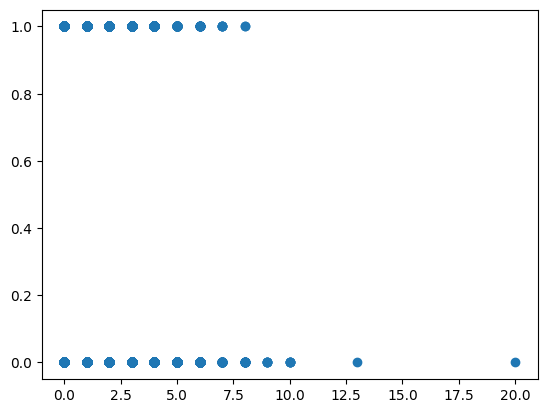

In [17]:
plt.scatter(train['NumberOfDependents'],train['SeriousDlqin2yrs'])

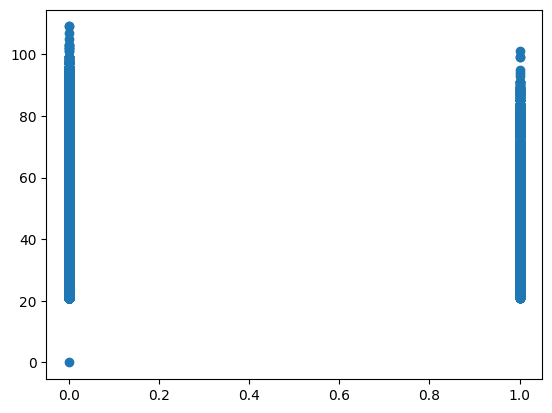

In [19]:
plt.scatter(train['SeriousDlqin2yrs'],train['age'])

The features : NumberOfDependents and age, feel unrelated to the outcome.

### 📌 Part 2: Data Preprocessing

1. How would you handle missing values in features like `MonthlyIncome` and `NumberOfDependents`?

In [20]:
train['MonthlyIncome'].fillna(train['MonthlyIncome'].median(),inplace=True)

In [23]:
train['NumberOfDependents'].fillna(0,inplace=True)

### 📌 Part 3: Train–Validation Setup

1. Why might a simple `train_test_split` be insufficient for imbalanced data?

Stratified Split
Preserves the proportion of classes in both train and validation sets.

In [56]:
X_train,X_val,y_train,y_val = train_test_split(train.drop(columns=['SeriousDlqin2yrs']),train['SeriousDlqin2yrs'],test_size=0.2,stratify=train['SeriousDlqin2yrs'],random_state=42)

In [63]:
X = train.drop(['SeriousDlqin2yrs'],axis=1)
y = train['SeriousDlqin2yrs']
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
auc_scores=[]

for fold,(train_idx,val_idx) in enumerate(skf.split(X,y)):
    print(f"------------Fold {fold+1}")
    X_train,X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train,y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    model = XGBClassifier(
                n_estimators = 300,
                learning_rate = 0.05,
                max_depth = 5,
                subsample = 1.0,
                scale_pos_weight = (y_train.value_counts()[0] / y_train.value_counts()[1]),
                random_state = 42,
                use_label_encoder = False,
                eval_metric = "auc"
            )
    model.fit(X_train,y_train,eval_set=[(X_val,y_val)],early_stopping_rounds=50,verbose=False)
    
    y_pred_proba = model.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val,y_pred_proba)
    auc_scores.append(auc)
    print(f"Fold {fold+1} AUC: {auc:.4f}")
    
print("Mean AUC across folds:", np.mean(auc_scores))   

------------Fold 1


/opt/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 1 AUC: 0.8641
------------Fold 2


/opt/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 2 AUC: 0.8649
------------Fold 3


/opt/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 3 AUC: 0.8703
------------Fold 4


/opt/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 4 AUC: 0.8596
------------Fold 5


/opt/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 5 AUC: 0.8679
Mean AUC across folds: 0.8653536959764911
